# Doing the NLP side

This notebook focuses on creating a model to classify the texts.

## Import Libraries

In [1]:
# change the python's path to the parent directory
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.lstm import LSTM
from sklearn.feature_extraction.text import CountVectorizer
from tools.tools import get_data, load_data, remove_class, tokenize, count_class, calculate_pos_weights
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## Load the data

### Performing Text Cleaning & Data Extraction (Possibly for NLP)

We will see how to code and clean the textual data for the following methods.
- Lowecasing the data
- Removing Puncuatations
- Removing Numbers
- Removing extra space
- Replacing the repetitions of punctations
- Removing Emojis
- Removing emoticons
- Removing Contractions
Reference: https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/

Manual Data Cleaning:
- Remove `\n` character that breaks the caption into two lines (1014.jpg)
- Remove `\n` character that breaks the caption into two lines (2259.jpg)
- Remove `\n` character that breaks the caption into two lines (6751.jpg)
- Remove **a couple of** `\n` character that breaks the caption into two lines (24624.jpg)

**Note: there is no label 12! [Label starts from 1 to 19]**

In [3]:
# import data
train_data = get_data("../dataset/train.csv")
test_data = get_data("../dataset/test.csv")

# perform text cleaning and get the pandas' dataframe
train_data = load_data(train_data)
test_data = load_data(test_data, has_label=False)

# remove an imbalanced class
train_data = remove_class(train_data, class_no=1)

# join the data together
for_nlp_data = pd.concat((train_data['caption'], test_data['caption']), ignore_index=True)

In [4]:
train_data['caption']

1        a couple of men riding horses on top of a gree...
3        a black and silver clock tower at an intersect...
4          a train coming to a stop on the tracks out side
6                a big airplane flying in the big blue sky
7                a man riding a motor bike across a forest
                               ...                        
29987      a school bus moving along a road during the day
29989    a brown and white dog a stuffed animal and a girl
29991           a large horse standing around in the grass
29994    an orange cat sitting on top of wooden floor b...
29995    a picture of a truck that is in the middle of ...
Name: caption, Length: 15925, dtype: object

In [5]:
test_data['caption']

0       a little girl waring a krispy kreme hat holdin...
1       a beautiful young woman holding an orange frisbee
2       a group of people sitting on couch next to a c...
3               a person on a snowboard rides on the hill
4       a man riding a skateboard with a helmet on in ...
                              ...                        
9995    a group of men riding surfboards riding a mass...
9996    a motorcycle parked next to a car in a parking...
9997              a little boy that is playing with a wii
9998    group of kids play frisbee golf in the middle ...
9999      a man in a gray jacket standing next to a woman
Name: caption, Length: 10000, dtype: object

## Count Vector

In [6]:
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(for_nlp_data)

X_train_vec = vectorizer.transform(train_data['caption'])
X_test_vec = vectorizer.transform(test_data['caption'])

In [7]:
# the size of vocabulary is 8075
print(X_train_vec.shape)
print(X_test_vec.shape)

(15925, 6585)
(10000, 6585)


In [8]:
X_train_tensor = torch.from_numpy(X_train_vec.todense()).int()
X_test_tensor = torch.from_numpy(X_test_vec.todense()).int()
y_train_tensor = torch.from_numpy(np.array(train_data.iloc[:, 2:]))
y_test_tensor = torch.from_numpy(np.array(test_data.iloc[:, 2:]))

### Instead of using Count Vectorizer, use Tokenization

In [9]:
final_list, vocab = tokenize(for_nlp_data)
X_train_vec = final_list[:train_data.shape[0], :]
X_test_vec = final_list[train_data.shape[0]:, :]
print(X_train_vec.shape)
print(X_test_vec.shape)
print(len(vocab))

# to tensor
X_train_tensor = torch.from_numpy(X_train_vec).int()
X_test_tensor = torch.from_numpy(X_test_vec).int()

Max Sentence Length: 28
(15925, 28)
(10000, 28)
6488


In [10]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16, 
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_data, 
    batch_size=16, 
    shuffle=False
)

## For Imbalance Data

In [11]:
t_data = get_data("../dataset/train.csv")
t_data = load_data(t_data)
class_counts = list(count_class(t_data).values())
pos_weights = calculate_pos_weights(class_counts, train_data)
if torch.cuda.is_available():
	pos_weights = pos_weights.to('cuda')

## Training the LSTM Model

In [12]:
EPOCHS = 500
THRESHOLD = 0.5

model = LSTM(
    no_layers=2,
    vocab_size=len(vocab), # extra 1 is already included, usually for padding
    embedding_dim=64,
    hidden_dim=256,
    output_dim=19,
)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')

using GPU


In [13]:
BATCH_SIZE = 16
clip = 5 # for exploding gradient problem
train_losses = []
train_accs = []
for epoch in range(EPOCHS):

	# initialize the hidden state
	hidden = model.init_hidden(batch_size=BATCH_SIZE)

	n_total = 0
	n_correct = 0
	train_loss = 0.
	model.train()
	for captions, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			captions = captions.to('cuda')
			labels = labels.to('cuda')

		# creating new variables for the hidden state, otherwise
		# we'd backprop through the entire training history
		hidden = tuple([each.data for each in hidden])

		model.zero_grad()
		y_pred, hidden = model(captions, hidden)

		# backward
		loss = loss_fn(y_pred.squeeze(), labels)
		loss.backward()

		# clip_grad_norm helps prevent the exploding gradient problem in RNNs/LSTMs
		nn.utils.clip_grad_norm_(model.parameters(), clip)

		# update
		optimizer.step()

		# compare
		predicted = (y_pred > THRESHOLD).int()

		train_loss += loss.item()
		n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
		n_total += labels.shape[0]

	train_losses.append(train_loss / len(train_loader))
	train_accs.append(n_correct / n_total)

	if (epoch % 20 == 0):
		print("Epoch {:d}, Train Loss: {:.9f}, Train Accuracy: {:.7f}%".format(epoch+1, train_losses[-1], train_accs[-1]*100))

Epoch 1 Training: 100%|██████████| 996/996 [00:03<00:00, 261.15it/s]


Epoch 1, Train Loss: 1.161094995, Train Accuracy: 0.2511774%


Epoch 21 Training: 100%|██████████| 996/996 [00:03<00:00, 284.59it/s]


Epoch 21, Train Loss: 0.914630120, Train Accuracy: 35.1271591%


Epoch 41 Training: 100%|██████████| 996/996 [00:03<00:00, 277.97it/s]


Epoch 41, Train Loss: 0.906082826, Train Accuracy: 38.2040825%


Epoch 61 Training: 100%|██████████| 996/996 [00:03<00:00, 257.86it/s]


Epoch 61, Train Loss: 0.903699091, Train Accuracy: 38.8320274%


Epoch 81 Training: 100%|██████████| 996/996 [00:03<00:00, 283.08it/s]


Epoch 81, Train Loss: 0.902445689, Train Accuracy: 39.1836777%


Epoch 101 Training: 100%|██████████| 996/996 [00:03<00:00, 273.06it/s]


Epoch 101, Train Loss: 0.900993569, Train Accuracy: 39.6106796%


Epoch 121 Training: 100%|██████████| 996/996 [00:03<00:00, 282.45it/s]


Epoch 121, Train Loss: 0.899899128, Train Accuracy: 39.8304596%


Epoch 141 Training: 100%|██████████| 996/996 [00:03<00:00, 277.79it/s]


Epoch 141, Train Loss: 0.899568148, Train Accuracy: 39.9120903%


Epoch 161 Training: 100%|██████████| 996/996 [00:03<00:00, 282.98it/s]


Epoch 161, Train Loss: 0.898353634, Train Accuracy: 40.3076935%


Epoch 181 Training: 100%|██████████| 996/996 [00:03<00:00, 281.63it/s]


Epoch 181, Train Loss: 0.898330322, Train Accuracy: 40.3076935%


Epoch 201 Training: 100%|██████████| 996/996 [00:03<00:00, 283.03it/s]


Epoch 201, Train Loss: 0.897474059, Train Accuracy: 40.5274734%


Epoch 221 Training: 100%|██████████| 996/996 [00:03<00:00, 281.66it/s]


Epoch 221, Train Loss: 0.897395864, Train Accuracy: 40.5651512%


Epoch 241 Training: 100%|██████████| 996/996 [00:04<00:00, 248.78it/s]


Epoch 241, Train Loss: 0.896665340, Train Accuracy: 40.6844635%


Epoch 261 Training: 100%|██████████| 996/996 [00:03<00:00, 282.70it/s]


Epoch 261, Train Loss: 0.896130821, Train Accuracy: 40.7723732%


Epoch 281 Training: 100%|██████████| 996/996 [00:03<00:00, 282.56it/s]


Epoch 281, Train Loss: 0.895907582, Train Accuracy: 40.9105225%


Epoch 301 Training: 100%|██████████| 996/996 [00:03<00:00, 278.28it/s]


Epoch 301, Train Loss: 0.895630141, Train Accuracy: 40.7912102%


Epoch 321 Training: 100%|██████████| 996/996 [00:03<00:00, 284.23it/s]


Epoch 321, Train Loss: 0.895268430, Train Accuracy: 40.9356384%


Epoch 341 Training: 100%|██████████| 996/996 [00:03<00:00, 280.26it/s]


Epoch 341, Train Loss: 0.895273666, Train Accuracy: 40.9984322%


Epoch 361 Training: 100%|██████████| 996/996 [00:03<00:00, 282.75it/s]


Epoch 361, Train Loss: 0.894717751, Train Accuracy: 40.9795952%


Epoch 381 Training: 100%|██████████| 996/996 [00:03<00:00, 286.82it/s]


Epoch 381, Train Loss: 0.894599024, Train Accuracy: 40.8916817%


Epoch 401 Training: 100%|██████████| 996/996 [00:03<00:00, 280.71it/s]


Epoch 401, Train Loss: 0.894132291, Train Accuracy: 41.0235481%


Epoch 421 Training: 100%|██████████| 996/996 [00:03<00:00, 281.18it/s]


Epoch 421, Train Loss: 0.894114446, Train Accuracy: 41.0486679%


Epoch 441 Training: 100%|██████████| 996/996 [00:03<00:00, 272.97it/s]


Epoch 441, Train Loss: 0.894009937, Train Accuracy: 41.1554184%


Epoch 461 Training: 100%|██████████| 996/996 [00:03<00:00, 282.91it/s]


Epoch 461, Train Loss: 0.893875645, Train Accuracy: 41.1930962%


Epoch 481 Training: 100%|██████████| 996/996 [00:03<00:00, 278.01it/s]


Epoch 481, Train Loss: 0.894046931, Train Accuracy: 41.1428604%


Epoch 500 Training: 100%|██████████| 996/996 [00:03<00:00, 280.58it/s]


In [14]:
# create a file for test submission
f = open('../submission_nlp.csv', "w")
f.write("ImageID,Labels\n")

# since test loader is not shuffling
index=30000

# initialize the hidden state
hidden = model.init_hidden(batch_size=BATCH_SIZE)

model.eval()
for captions, _ in tqdm(test_loader, desc="Testing: "):
	
	if torch.cuda.is_available():
		captions = captions.to('cuda')

	# creating new variables for the hidden state, otherwise
	# we'd backprop through the entire training history
	hidden = tuple([each.data for each in hidden])
	
	outputs, _ = model(captions, hidden)
	predicted = (F.sigmoid(outputs) > THRESHOLD).int()

	# NOTE: add 1 to the output of predicted!
	# write the output
	for i, predicted_label in enumerate(predicted):
		label = (predicted_label == torch.max(predicted_label)).nonzero().flatten()
		label += 1
		label = label.tolist()
		label = " ".join(str(x) for x in label)

		f.write(f"{index}.jpg" + "," + str(label) +"\n")
		index += 1

f.close()

Testing: 100%|██████████| 625/625 [00:01<00:00, 388.76it/s]


In [15]:
import matplotlib.pyplot as plt

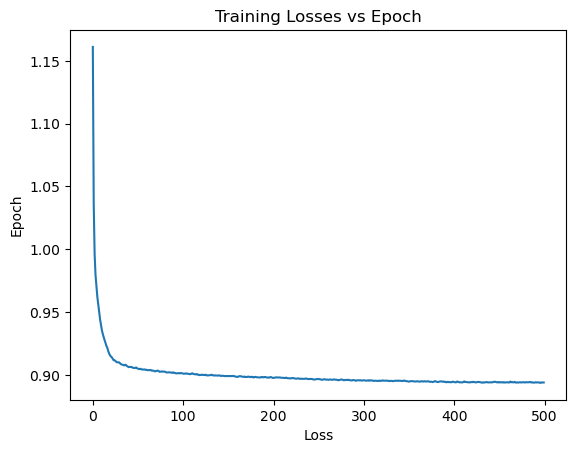

In [16]:
plt.title("Training Losses vs Epoch")
plt.plot(train_losses)
plt.ylabel("Epoch")
plt.xlabel("Loss")
plt.show()

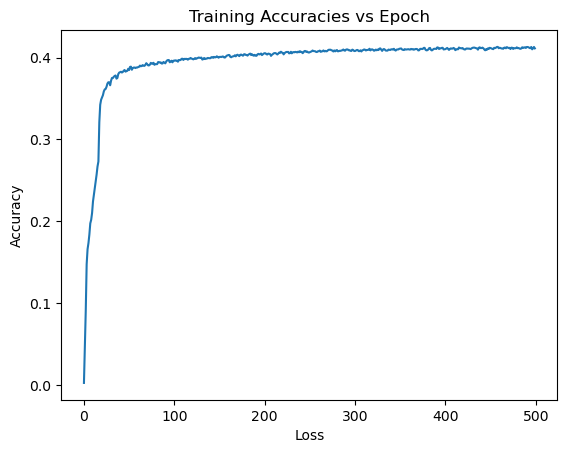

In [17]:
new_train_accs = []
for train_acc in train_accs:
    new_train_accs.append(train_acc.item())

plt.title("Training Accuracies vs Epoch")
plt.plot(new_train_accs)
plt.ylabel("Accuracy")
plt.xlabel("Loss")
plt.show()

In [18]:
torch.save(model.state_dict(), '../lstm_2_token_64_256_19.pth')

In [19]:
model = LSTM(
    no_layers=2,
    vocab_size=len(vocab), # extra 1 is already included, usually for padding
    embedding_dim=64,
    hidden_dim=256,
    output_dim=19,
)
model.load_state_dict(torch.load('../lstm_2_token_64_256_19.pth'))

<All keys matched successfully>

: 